In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings

# Configurações globais
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [38]:
# Carregar dataset limpo
try:
    df = pd.read_csv("pokemon_dataset_cleaned.csv")
    print("✓ Dataset carregado com sucesso!")
    print(f"   Total de Pokémon: {len(df)}")
except FileNotFoundError:
    print("ERRO: 'pokemon_dataset_cleaned.csv' não encontrado. Verifique o caminho do arquivo.")

# Seleção de Features e Limpeza final
numeric_features = ['Height', 'Weight', 'HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', 'Speed']
target_reg = 'CatchRate'
target_clf = 'Group'  # Alvo multiclasse!

# Remove linhas com nulos nas colunas que vamos usar
df_model = df.dropna(subset=numeric_features + [target_reg, target_clf]).copy()

print(f"\n✓ Dataset preparado para modelagem:")
print(f"   Shape: {df_model.shape}")
print(f"   Features numéricas: {len(numeric_features)}")

print(f"\n📊 Distribuição dos Grupos (Target Multiclasse):")
group_counts = df_model['Group'].value_counts().sort_values(ascending=False)
for group, count in group_counts.items():
    percentage = (count / len(df_model)) * 100
    print(f"   {group:20s}: {count:4d} ({percentage:5.2f}%)")

print(f"\n💡 Total de classes: {df_model['Group'].nunique()}")

✓ Dataset carregado com sucesso!
   Total de Pokémon: 1199

✓ Dataset preparado para modelagem:
   Shape: (290, 27)
   Features numéricas: 8

📊 Distribuição dos Grupos (Target Multiclasse):
   Legendary           :  106 (36.55%)
   Starter             :   86 (29.66%)
   Pseudo-Legendary    :   36 (12.41%)
   Mythical            :   31 (10.69%)
   Paradox             :   20 ( 6.90%)
   Ultra Beast         :   11 ( 3.79%)

💡 Total de classes: 6


---

# 📊 Análise Preditiva de Pokémon - Modelagem Avançada

Este notebook contém a implementação completa dos modelos de Machine Learning para:

1. **Regressão**: Prever a Taxa de Captura (`CatchRate`) baseada nos stats do Pokémon
2. **Classificação Multiclasse**: Identificar o Grupo do Pokémon (Legendary, Starter, Mythical, etc.)

**Dataset utilizado**: `pokemon_dataset_cleaned.csv`
- Dados já pré-processados e limpos
- Colunas padronizadas (HP, Attack, Defense, SpAtk, SpDef, Speed, BST, CatchRate, Group)

---

## 1. Carregamento e Preparação dos Dados

---

## 2. Análise Exploratória dos Grupos

Antes de construir os modelos, vamos entender as diferenças entre os grupos de Pokémon através de visualizações e testes estatísticos.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


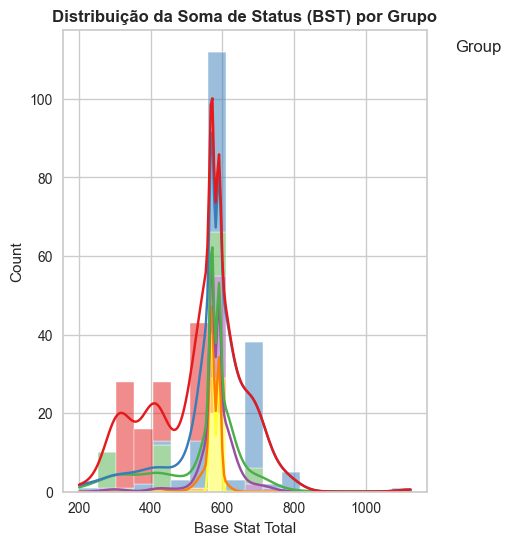

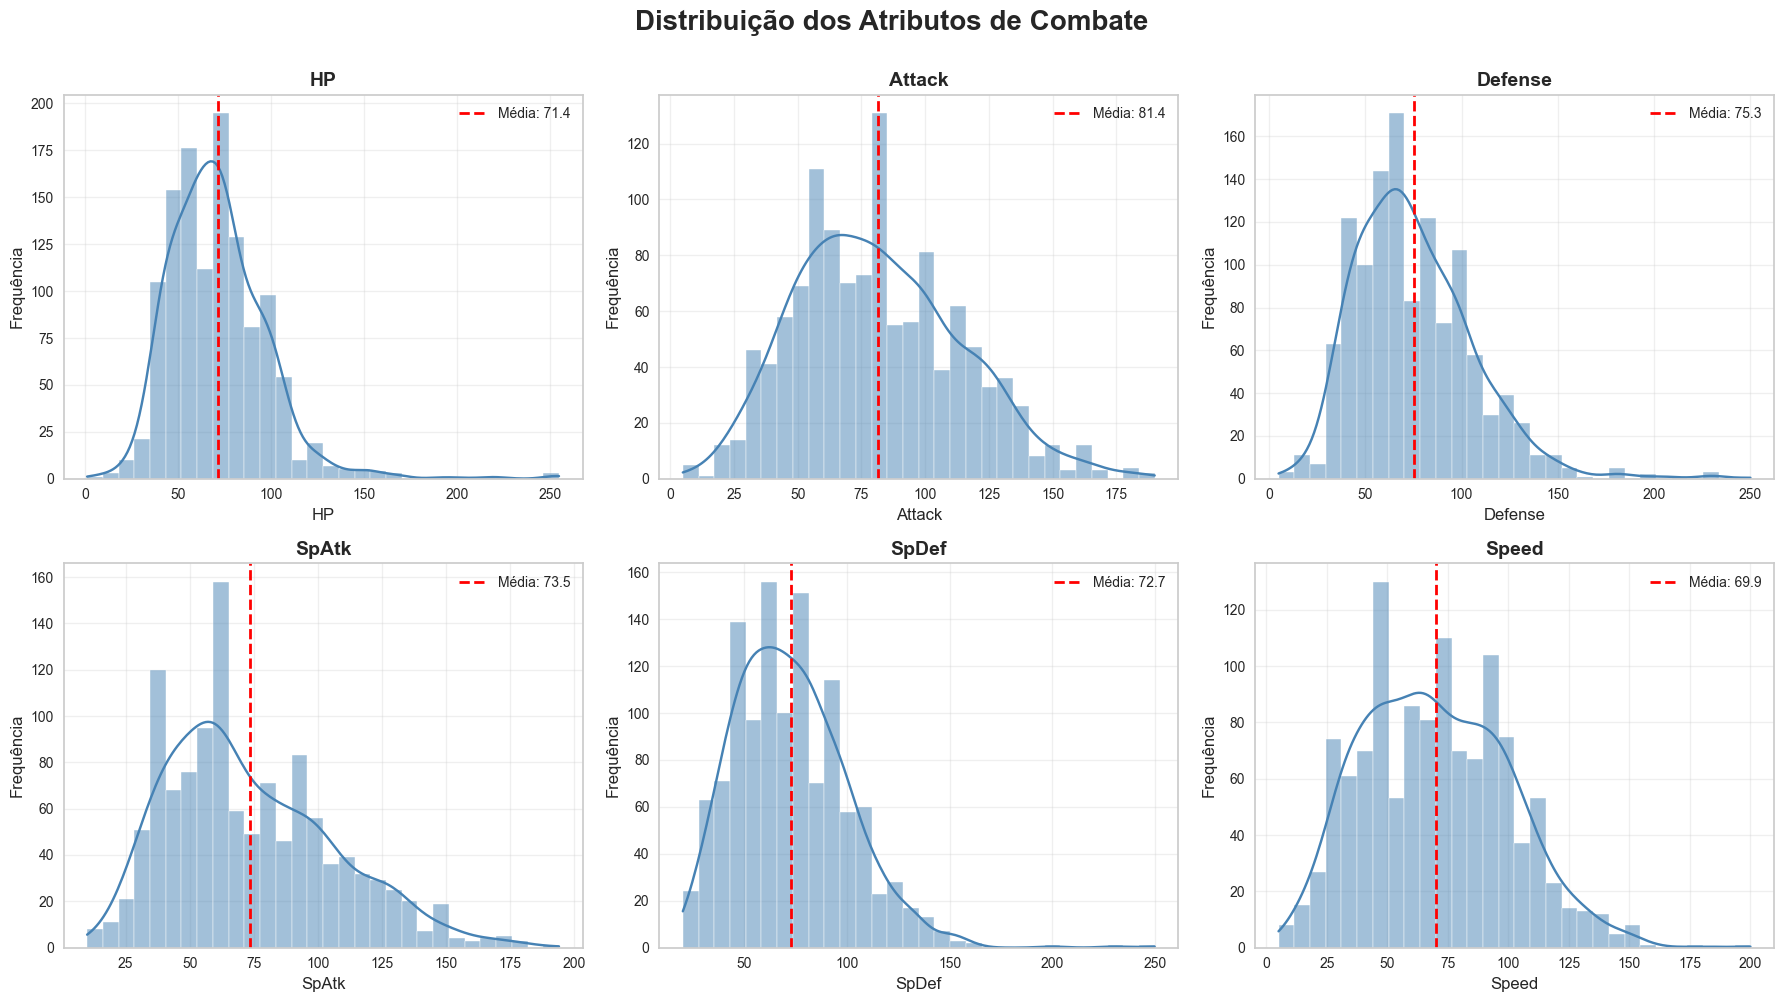

ESTATÍSTICAS DESCRITIVAS DOS ATRIBUTOS DE COMBATE
            HP   Attack  Defense    SpAtk    SpDef    Speed
count  1199.00  1199.00  1199.00  1199.00  1199.00  1199.00
mean     71.41    81.41    75.30    73.52    72.65    69.91
std      27.00    32.13    30.85    32.79    27.67    30.12
min       1.00     5.00     5.00    10.00    20.00     5.00
25%      52.50    57.50    53.00    50.00    51.00    45.00
50%      70.00    80.00    70.00    65.00    70.00    68.00
75%      85.00   100.00    94.50    95.00    90.00    91.00
max     255.00   190.00   250.00   194.00   250.00   200.00


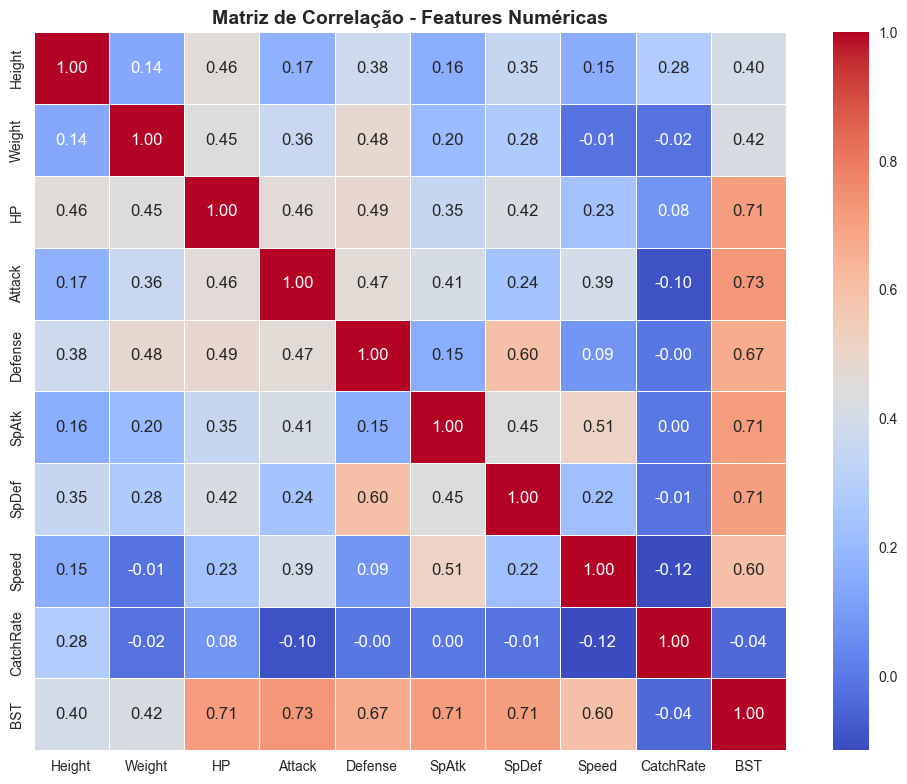


ESTATÍSTICAS DESCRITIVAS POR GRUPO

HP:
                   mean    std  min  max
Group                                   
Legendary         98.67  30.10   43  255
Paradox           95.90  22.65   55  154
Ultra Beast       91.18  47.72   53  223
Mythical          83.71  22.83   46  135
Pseudo-Legendary  72.25  22.05   28  115
Starter           66.42  17.07   39  110

Attack:
                    mean    std  min  max
Group                                    
Legendary         110.96  29.69   29  190
Ultra Beast       109.55  37.32   53  181
Mythical          107.90  28.22   65  180
Paradox           103.40  29.37   55  140
Pseudo-Legendary   97.72  33.37   50  170
Starter            76.43  21.34   40  125

Defense:
                   mean    std  min  max
Group                                   
Legendary         99.87  28.29   31  250
Mythical          95.81  30.87   20  160
Paradox           94.50  19.84   55  131
Ultra Beast       89.55  52.41   37  211
Pseudo-Legendary  81.22  31.22

In [39]:
# ============================================================================
# ANÁLISE EXPLORATÓRIA DOS GRUPOS
# ============================================================================

# 1. Visualização: Distribuição de BST por Grupo
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.histplot(data=df_model, x='BST', hue='Group', kde=True, palette='Set1', multiple='stack')
plt.title('Distribuição da Soma de Status (BST) por Grupo', fontsize=12, fontweight='bold')
plt.xlabel('Base Stat Total')
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# 2. Distribuição dos atributos de combate por 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

combat_stats = ['HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', 'Speed']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribuição dos Atributos de Combate', fontsize=20, fontweight='bold', y=1.00)

for idx, stat in enumerate(combat_stats):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Histograma com KDE
    sns.histplot(data=df, x=stat, kde=True, bins=30, color='steelblue', ax=ax)
    
    # Adicionar linha vertical da média
    mean_val = df[stat].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.1f}')
    
    # Configurações
    ax.set_title(f'{stat}', fontsize=14, fontweight='bold')
    ax.set_xlabel(stat, fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*80)
print("ESTATÍSTICAS DESCRITIVAS DOS ATRIBUTOS DE COMBATE")
print("="*80)
print(df[combat_stats].describe().round(2).to_string())
print("="*80)

# 3. Matriz de Correlação
plt.figure(figsize=(10, 8))
corr = df_model[numeric_features + ['CatchRate', 'BST']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação - Features Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Análise Estatística: Comparar médias entre grupos
print("\n" + "="*80)
print("ESTATÍSTICAS DESCRITIVAS POR GRUPO")
print("="*80)

for feature in ['HP', 'Attack', 'Defense', 'Speed', 'BST']:
    print(f"\n{feature}:")
    stats_by_group = df_model.groupby('Group')[feature].agg(['mean', 'std', 'min', 'max'])
    stats_by_group = stats_by_group.sort_values('mean', ascending=False)
    print(stats_by_group.round(2))

# 5. Teste ANOVA: Verificar se há diferença significativa entre os grupos
from scipy.stats import f_oneway

print("\n" + "="*80)
print("TESTE ANOVA - DIFERENÇAS ENTRE GRUPOS")
print("="*80)

for feature in ['Attack', 'Defense', 'Speed', 'HP']:
    grupos = [group[feature].values for name, group in df_model.groupby('Group')]
    f_stat, p_val = f_oneway(*grupos)
    print(f"\n{feature}:")
    print(f"   F-Statistic: {f_stat:.4f}")
    print(f"   P-Valor: {p_val:.4e}")
    if p_val < 0.05:
        print(f"   ✓ Diferença significativa entre grupos!")
    else:
        print(f"   ✗ Nenhuma diferença significativa encontrada.")

---

## 3. Modelagem de Regressão

**Objetivo**: Prever a Taxa de Captura (CatchRate) de um Pokémon baseado em seus stats.

**Modelos implementados**:
- Ordinary Least Squares (OLS) com diagnóstico completo
- Regressão Polinomial (grau 2) para capturar relações não-lineares

In [40]:
# --- 4. MODELAGEM DE REGRESSÃO (Prever Catch Rate) ---
# Preparar dados para Regressão
X = df_model[numeric_features]
y = df_model[target_reg]

# Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo OLS (com intercepto) usando statsmodels
# O statsmodels exige adicionar uma constante manualmente para o intercepto
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_sm).fit()

# Exibir o sumário estatístico completo
print(model_ols.summary())

# Diagnóstico de Multicolinearidade (VIF)
vif = pd.DataFrame()
vif["Feature"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print("\n--- Análise de VIF (Multicolinearidade) ---\n", vif)

# Avaliação no Teste
X_test_sm = sm.add_constant(X_test)
y_pred = model_ols.predict(X_test_sm)

# Cálculo das Métricas de Regressão (Corrigido para versões antigas do sklearn)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Raiz quadrada do MSE calculada manualmente com numpy
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas de Regressão (Teste) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:              CatchRate   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.499
Date:                Wed, 10 Dec 2025   Prob (F-statistic):             0.0129
Time:                        00:02:38   Log-Likelihood:                -1169.7
No. Observations:                 232   AIC:                             2357.
Df Residuals:                     223   BIC:                             2388.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.5889     12.135      5.240      0.0

A análise do modelo OLS mostra que 'HP', 'Attack' e 'Speed' possuem coeficientes negativos significativos (P<0.05). Isso faz sentido no contexto do jogo: quanto mais fortes os status do Pokémon, menor é a Taxa de Captura (mais difícil de pegar). O R² de 0.47 indica que os status explicam quase 50% da variação da dificuldade de captura.

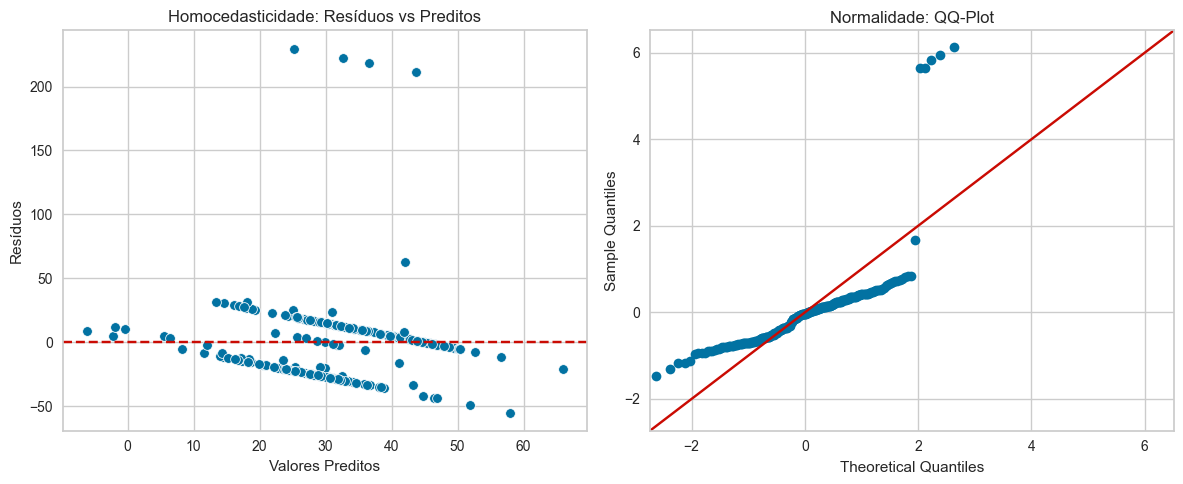

Teste de Normalidade (Shapiro-Wilk): P-Valor = 3.9865e-23


In [41]:
# Diagnóstico de Resíduos (Obrigatório na Ementa)
residuals = model_ols.resid
fitted = model_ols.fittedvalues

plt.figure(figsize=(12, 5))

# 1. Homocedasticidade (Resíduos vs Preditos)
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Homocedasticidade: Resíduos vs Preditos')

# 2. Normalidade (QQ-Plot)
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Normalidade: QQ-Plot')

plt.tight_layout()
plt.show()

# Teste de Shapiro-Wilk para confirmar normalidade (Opcional, mas impressiona)
stat, p_val = stats.shapiro(residuals)
print(f"Teste de Normalidade (Shapiro-Wilk): P-Valor = {p_val:.4e}")

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# --- 4.1. COMPARAÇÃO: REGRESSÃO POLINOMIAL ---
# A ementa pede para testar regressão polinomial. Vamos ver se grau 2 melhora o resultado.

print("--- Treinando Regressão Polinomial (Grau 2) ---")

# Criar pipeline: Gera features polinomiais -> Aplica Regressão Linear
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)

# Previsão
y_pred_poly = poly_model.predict(X_test)

# Métricas Polinomial
# Nota: Se o seu sklearn for antigo, mantivemos o cálculo manual do RMSE
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"R² Polinomial: {r2_poly:.4f}")
print(f"RMSE Polinomial: {rmse_poly:.2f}")

# Comparação com o modelo Linear anterior (OLS)
r2_linear = r2_score(y_test, y_pred) # y_pred vem da célula anterior

print("\n--- Veredito: Linear vs Polinomial ---")
if r2_poly > r2_linear:
    print(f"A Regressão Polinomial foi MELHOR (R² {r2_poly:.4f} vs {r2_linear:.4f}).")
    print("Isso indica relações não-lineares entre os status e a taxa de captura.")
else:
    print(f"A Regressão Linear foi MELHOR ou IGUAL (R² {r2_linear:.4f} vs {r2_poly:.4f}).")
    print("O modelo mais simples é preferível (Navalha de Ockham).")

--- Treinando Regressão Polinomial (Grau 2) ---
R² Polinomial: -63.1605
RMSE Polinomial: 517.55

--- Veredito: Linear vs Polinomial ---
A Regressão Linear foi MELHOR ou IGUAL (R² -0.1978 vs -63.1605).
O modelo mais simples é preferível (Navalha de Ockham).


---

## 5. Classificação Multiclasse: Predição do Grupo do Pokémon

Agora vamos além da regressão e criar um modelo que **classifica cada Pokémon no seu grupo correto** (Legendary, Starter, Mythical, etc.).

**Diferenças em relação à classificação binária:**
- **Target multiclasse**: Em vez de apenas 0/1, temos 6 classes diferentes
- **Random Forest**: Geralmente funciona melhor que Regressão Logística para múltiplas classes
- **Balanceamento**: Usamos `class_weight='balanced'` para lidar com grupos menores (Ultra Beast, Paradox)
- **Métricas**: Precisão, Recall e F1-Score para **cada grupo individualmente**

**Por que isso é útil?**
- Permite identificar padrões únicos de cada grupo
- Útil para classificar novos Pokémon em futuras gerações
- Ajuda a entender quais features distinguem melhor cada categoria

CLASSIFICAÇÃO MULTICLASSE: PREDIÇÃO DO GRUPO DO POKÉMON

📋 Classes identificadas (6):
   0: Legendary            ( 106 exemplos)
   1: Mythical             (  31 exemplos)
   2: Paradox              (  20 exemplos)
   3: Pseudo-Legendary     (  36 exemplos)
   4: Starter              (  86 exemplos)
   5: Ultra Beast          (  11 exemplos)

✓ Dados preparados:
   Treino: 232 exemplos
   Teste: 58 exemplos

🌳 Treinando Random Forest Classifier...

RESULTADOS - CONJUNTO DE TREINO
                  precision    recall  f1-score   support

       Legendary       0.99      0.96      0.98        84
        Mythical       0.96      0.92      0.94        25
         Paradox       1.00      1.00      1.00        16
Pseudo-Legendary       0.97      1.00      0.98        29
         Starter       0.97      1.00      0.99        69
     Ultra Beast       1.00      1.00      1.00         9

        accuracy                           0.98       232
       macro avg       0.98      0.98      0.98  

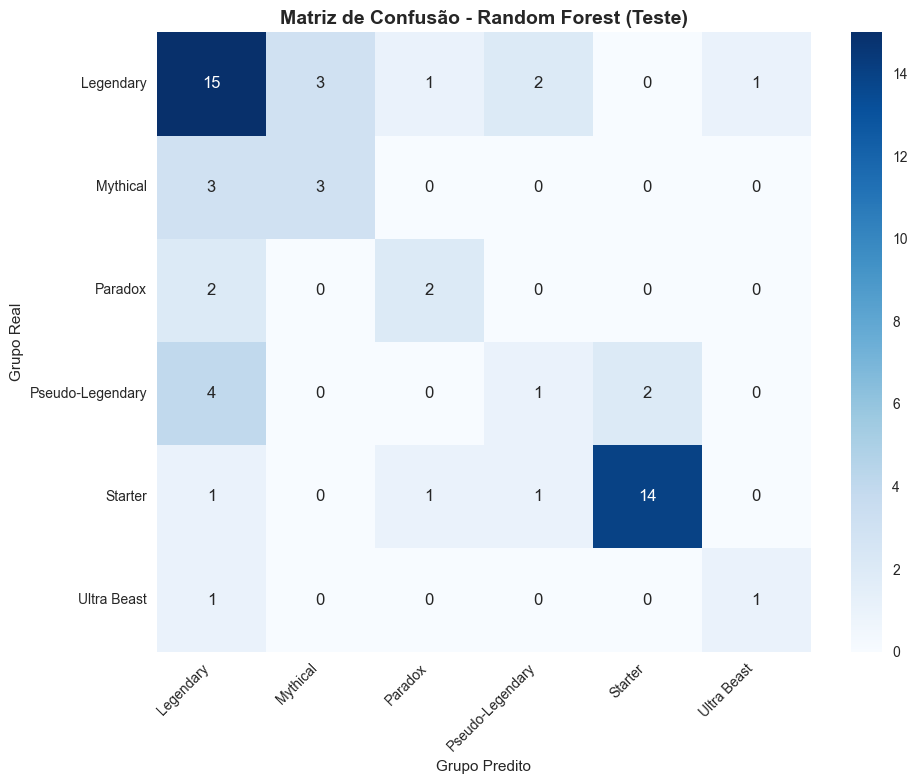


💡 Interpretação da Matriz de Confusão:
   - Diagonal principal: Predições corretas
   - Fora da diagonal: Confusões entre grupos
   - Observe onde o modelo mais erra!


In [43]:
# --- 5. MODELAGEM DE CLASSIFICAÇÃO MULTICLASSE (Prever Group) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

print("="*80)
print("CLASSIFICAÇÃO MULTICLASSE: PREDIÇÃO DO GRUPO DO POKÉMON")
print("="*80)

# 1. Preparar dados para Classificação Multiclasse
X_cls = df_model[numeric_features]
y_cls = df_model[target_clf]

# 2. Codificar os nomes dos grupos em números (0, 1, 2, 3...)
label_encoder = LabelEncoder()
y_cls_encoded = label_encoder.fit_transform(y_cls)

# Guardar o mapeamento das classes
class_names = label_encoder.classes_
print(f"\n📋 Classes identificadas ({len(class_names)}):")
for idx, name in enumerate(class_names):
    count = (y_cls == name).sum()
    print(f"   {idx}: {name:20s} ({count:4d} exemplos)")

# 3. Divisão Treino/Teste Estratificada (mantém proporção de cada grupo)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_cls_encoded
)

# 4. Padronização (Crucial para modelos baseados em distância)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

print(f"\n✓ Dados preparados:")
print(f"   Treino: {X_train_scaled.shape[0]} exemplos")
print(f"   Teste: {X_test_scaled.shape[0]} exemplos")

# 5. Treinar Random Forest Classifier com balanceamento de classes
print("\n🌳 Treinando Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Ajuda com classes desbalanceadas
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train_c)

# 6. Previsões
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

print("\n" + "="*80)
print("RESULTADOS - CONJUNTO DE TREINO")
print("="*80)
print(classification_report(y_train_c, y_pred_train, target_names=class_names, zero_division=0))

print("\n" + "="*80)
print("RESULTADOS - CONJUNTO DE TESTE")
print("="*80)
print(classification_report(y_test_c, y_pred_test, target_names=class_names, zero_division=0))

# 7. Importância das Features
print("\n📊 Importância das Features:")
feature_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance.to_string(index=False))

# 8. Matriz de Confusão com nomes dos grupos
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_c, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - Random Forest (Teste)', fontsize=14, fontweight='bold')
plt.ylabel('Grupo Real')
plt.xlabel('Grupo Predito')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 Interpretação da Matriz de Confusão:")
print("   - Diagonal principal: Predições corretas")
print("   - Fora da diagonal: Confusões entre grupos")
print("   - Observe onde o modelo mais erra!")

In [44]:
from pycaret.regression import setup as setup_reg
from pycaret.regression import compare_models as compare_reg
from pycaret.regression import tune_model as tune_reg
from pycaret.regression import pull as pull_reg

print("--- Otimização com PyCaret (Regressão) ---")
# Setup do PyCaret (automático)
reg_experiment = setup_reg(data=df_model, target='CatchRate', session_id=42, verbose=False)

# Comparar modelos
best_reg = compare_reg(sort='R2', n_select=1)
print(pull_reg())

# Tunar o melhor modelo
tuned_reg = tune_reg(best_reg, optimize='R2')

--- Otimização com PyCaret (Regressão) ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,18.4438,692.4196,24.0372,0.3401,1.1971,3.0248,0.0850
et,Extra Trees Regressor,20.4271,728.4449,24.9852,0.2290,1.2819,3.4608,0.1160
rf,Random Forest Regressor,20.7622,764.6156,25.6700,0.2234,1.2716,3.3814,0.0880
omp,Orthogonal Matching Pursuit,16.4140,639.1847,22.9238,0.2214,1.1327,2.6988,0.0720
gbr,Gradient Boosting Regressor,20.5462,696.7153,24.4092,0.2186,1.2995,3.5613,0.0790
dt,Decision Tree Regressor,20.3876,681.9695,24.0160,0.2068,1.2948,3.4891,0.0460
ada,AdaBoost Regressor,21.9362,1125.5404,29.9001,0.0642,1.3069,3.5372,0.0520
llar,Lasso Least Angle Regression,22.8484,1280.0983,32.4142,0.0121,1.3328,3.6984,0.0610
lasso,Lasso Regression,22.8792,1288.9617,32.5097,0.0088,1.3338,3.7020,0.0640
ridge,Ridge Regression,22.9961,1294.7778,32.6169,-0.0008,1.3380,3.7281,0.0490


                                    Model           MAE           MSE  \
en                            Elastic Net  1.844380e+01  6.924196e+02   
et                  Extra Trees Regressor  2.042710e+01  7.284449e+02   
rf                Random Forest Regressor  2.076220e+01  7.646156e+02   
omp           Orthogonal Matching Pursuit  1.641400e+01  6.391847e+02   
gbr           Gradient Boosting Regressor  2.054620e+01  6.967153e+02   
dt                Decision Tree Regressor  2.038760e+01  6.819695e+02   
ada                    AdaBoost Regressor  2.193620e+01  1.125540e+03   
llar         Lasso Least Angle Regression  2.284840e+01  1.280098e+03   
lasso                    Lasso Regression  2.287920e+01  1.288962e+03   
ridge                    Ridge Regression  2.299610e+01  1.294778e+03   
knn                 K Neighbors Regressor  1.730830e+01  1.298028e+03   
lr                      Linear Regression  2.346760e+01  1.411421e+03   
br                         Bayesian Ridge  2.346720

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,16.3176,318.1393,17.8365,0.2699,1.2066,3.1477
1,18.0191,538.3006,23.2013,0.8068,1.1334,2.5914
2,17.7621,513.1109,22.6520,0.8204,1.1843,2.9765
3,17.1555,393.6793,19.8414,-0.1287,1.4087,4.2333
4,24.3081,2783.6888,52.7607,0.0411,1.2383,2.8407
5,13.2979,221.3992,14.8795,0.4653,1.0647,2.4052
6,13.3237,216.9808,14.7303,0.4394,0.9575,1.9369
7,18.7733,603.7957,24.5723,0.7952,1.1948,3.0134
8,13.7969,211.5759,14.5456,0.3993,0.9162,1.7958


Fitting 10 folds for each of 10 candidates, totalling 100 fits


---

## 6. Otimização Automática com PyCaret

PyCaret é uma biblioteca que automatiza o processo de seleção e tunagem de modelos, testando diversos algoritmos em paralelo.

In [36]:
from pycaret.classification import setup as setup_clf
from pycaret.classification import compare_models as compare_clf
from pycaret.classification import tune_model as tune_clf
from pycaret.classification import pull as pull_clf

print("="*80)
print("OTIMIZAÇÃO COM PYCARET - CLASSIFICAÇÃO MULTICLASSE")
print("="*80)

# Preparar DataFrame para PyCaret (precisa das features + target original)
df_pycaret = df_model[numeric_features + ['Group']].copy()

print(f"\n✓ Dataset preparado para PyCaret:")
print(f"   Shape: {df_pycaret.shape}")
print(f"   Target: Group (multiclasse)")

# Setup do PyCaret para classificação multiclasse
print("\n🔧 Configurando experimento...")
clf_experiment = setup_clf(
    data=df_pycaret, 
    target='Group',
    session_id=42,
    fix_imbalance=True,  # Tenta balancear as classes
    normalize=True,      # Normaliza as features
    verbose=False,
    html=False
)

print("\n🔍 Comparando diferentes modelos de classificação...")
print("   (Isso pode levar alguns minutos...)\n")

# Comparar modelos (top 5 por F1-Score)
best_clf = compare_clf(sort='F1', n_select=5)
print("\n📊 Ranking dos Modelos:")
print(pull_clf())

print("\n🎯 Tunando o melhor modelo...")
# Tunar o melhor modelo
tuned_clf = tune_clf(best_clf[0], optimize='F1', n_iter=10)

print("\n✓ Otimização concluída!")
print("\n💡 Dicas:")
print("   - Use 'evaluate_model(tuned_clf)' para ver visualizações detalhadas")
print("   - Use 'predict_model(tuned_clf)' para fazer previsões no conjunto de teste")
print("   - Use 'save_model(tuned_clf, 'meu_modelo')' para salvar o modelo")

OTIMIZAÇÃO COM PYCARET - CLASSIFICAÇÃO MULTICLASSE

✓ Dataset preparado para PyCaret:
   Shape: (290, 9)
   Target: Group (multiclasse)

🔧 Configurando experimento...

🔍 Comparando diferentes modelos de classificação...
   (Isso pode levar alguns minutos...)



                                    Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.6395  0.0000  0.6395  0.6567   
lightgbm  Light Gradient Boosting Machine    0.6498  0.7041  0.6498  0.6741   
rf               Random Forest Classifier    0.6448  0.6973  0.6448  0.6493   
et                 Extra Trees Classifier    0.6452  0.6968  0.6452  0.6320   
qda       Quadratic Discriminant Analysis    0.5829  0.0000  0.5829  0.5977   
dt               Decision Tree Classifier    0.5024  0.5572  0.5024  0.5436   
lr                    Logistic Regression    0.4536  0.0000  0.4536  0.5909   
knn                K Neighbors Classifier    0.4526  0.6126  0.4526  0.5432   
lda          Linear Discriminant Analysis    0.3848  0.0000  0.3848  0.5158   
svm                   SVM - Linear Kernel    0.3795  0.0000  0.3795  0.5600   
ada                  Ada Boost Classifier    0.3898  0.0000  0.3898  0.4593   
ridge                    Ridge Classifier    0.3798 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.6667  0.0  0.6667  0.6723  0.6667  0.5664  0.5680
1       0.7619  0.0  0.7619  0.8214  0.7778  0.6866  0.6908
2       0.6667  0.0  0.6667  0.6492  0.6442  0.5702  0.5804
3       0.6500  0.0  0.6500  0.6571  0.6469  0.5254  0.5347
4       0.7000  0.0  0.7000  0.6431  0.6574  0.5668  0.5848
5       0.6000  0.0  0.6000  0.7333  0.6233  0.4822  0.5086
6       0.6500  0.0  0.6500  0.6262  0.6336  0.5205  0.5241
7       0.6000  0.0  0.6000  0.5400  0.5667  0.4245  0.4297
8       0.8000  0.0  0.8000  0.7542  0.7700  0.7288  0.7340
9       0.5500  0.0  0.5500  0.5587  0.5245  0.3750  0.3838
Mean    0.6645  0.0  0.6645  0.6656  0.6511  0.5446  0.5539
Std     0.0714  0.0  0.0714  0.0815  0.0740  0.1019  0.1003

✓ Otimização concluída!

💡 Dicas:
   - Use 'evaluate_model(tuned_clf)' para ver visualizações detalhadas
   - Use 'predict_model(tuned_clf)' para fazer previsõ

---

## 📝 Resumo e Conclusões

### Modelos Implementados

**1. Regressão (Prever CatchRate)**:
- ✓ OLS com diagnóstico completo (VIF, resíduos, normalidade)
- ✓ Regressão Polinomial (grau 2) para relações não-lineares
- ✓ Comparação de métricas (R², MAE, RMSE)

**2. Classificação Multiclasse (Prever Group)**:
- ✓ Random Forest Classifier com balanceamento de classes
- ✓ Classification Report por grupo
- ✓ Matriz de Confusão visual com nomes dos grupos
- ✓ Análise de importância das features

**3. Otimização Automática**:
- ✓ PyCaret para seleção e tunagem automática de modelos
- ✓ Comparação de múltiplos algoritmos
- ✓ Hyperparameter tuning

---

### Interpretação dos Resultados

**Classificação Multiclasse - O que observar:**

1. **Precision por grupo**: Quando o modelo diz que um Pokémon é do grupo X, qual a % de acerto?
2. **Recall por grupo**: De todos os Pokémon reais do grupo X, quantos % o modelo conseguiu identificar?
3. **F1-Score**: Média harmônica entre Precision e Recall (métrica balanceada)

**Matriz de Confusão - Insights:**
- **Diagonal**: Acertos (quanto maior, melhor)
- **Fora da diagonal**: Confusões comuns
  - Ex: Modelo confunde Legendary com Mythical? (são parecidos em stats)
  - Ex: Starter mal classificado como Regular? (stats mais baixos)

**Importância das Features:**
- Quais stats são mais relevantes para diferenciar os grupos?
- BST alto geralmente indica Legendary/Mythical
- Balance entre Attack/Defense pode indicar Starter